In [ ]:
import numpy as np
import torch
import torch.nn as nn
from keras.datasets import mnist
from matplotlib import pyplot as plt
import math
from tqdm import tqdm
import torchvision
import torchvision.datasets

In [ ]:
EPOCHS = 50
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODELS = []
BATCH_SIZE = 100

In [ ]:
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 143346726.77it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 22946712.22it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 50757718.34it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18424109.06it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



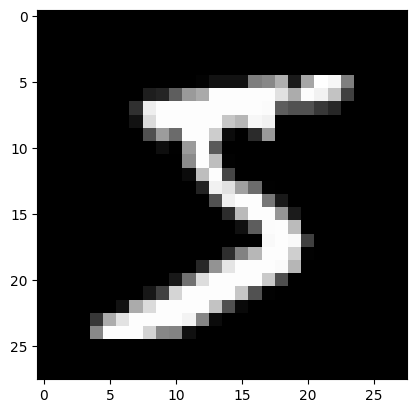

In [ ]:
plt.subplot()
plt.imshow(trainset[0][0].squeeze(0), cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
#DataLoader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset = trainset,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = testset,
                              batch_size = BATCH_SIZE,
                              shuffle = False)

In [ ]:
class LatentfromX(nn.Module):
    def __init__(self, input_channels, latent_dims):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(in_features = input_channels, out_features = 256),
            nn.Tanh(),
            nn.Linear(in_features = 256, out_features = 64),
            nn.Tanh()
        )
        self.mean_layer = nn.Sequential(
            nn.Linear(in_features = 64, out_features = latent_dims),
            nn.Tanh()
        )
        self.log_var_layer = nn.Sequential(
            nn.Linear(in_features=64, out_features=latent_dims),
            nn.Tanh()
        )

    def forward(self, z):
        z = self.stack(z)
        return self.mean_layer(z), self.log_var_layer(z)

In [ ]:
class ReconstructFromLatent(nn.Module):
    def __init__(self, latent_dims, output_dims):
        super().__init__()
        self.stack = nn.Sequential(
            nn.Linear(in_features=latent_dims, out_features=196),
            nn.Tanh(),
            nn.Linear(in_features=196, out_features=256),
            nn.Tanh(),
            nn.Linear(in_features=256, out_features=576),
            nn.Tanh(),
        )
        self.reconstruct = nn.Sequential(
            nn.Linear(in_features=576, out_features=output_dims),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.stack(x)
        return self.reconstruct(x)

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()
        #q(z|x)
        self.qz_x = LatentfromX(input_channels=28*28, latent_dims=latent_dims)
        #p(x|z)
        self.px_z = ReconstructFromLatent(latent_dims=latent_dims, output_dims=28*28)

    def forward(self, x):
        z_mean, z_log_var = self.qz_x(x)
        reparameterized = z_mean + (torch.exp(z_log_var * 0.5) * torch.randn_like(z_log_var).to(DEVICE))
        reconstructed_x = self.px_z(reparameterized)
        return z_mean, z_log_var, reconstructed_x

In [ ]:
reconstruction_error_history = []
kl_div_error_history= []
total_error_history = []
for i in range(6):
  reconstruction_error_history.append([])
  kl_div_error_history.append([])
  total_error_history.append([])
  latent_dims = 2**(i+1)
  VAEModel = VAE(latent_dims=latent_dims).to(DEVICE)
  optimizer = torch.optim.Adam(params=VAEModel.parameters(), lr=1e-3)
  loss_fn = nn.MSELoss(reduction="sum")
  VAEModel.train()
  for epoch in (range(EPOCHS)):
      loss=0
      total_reconstruction_error = 0
      total_kl_div_error = 0
      total_error = 0
      for batch, (x,y) in tqdm(enumerate(train_dataloader)):
          x=x.view(BATCH_SIZE, 28*28).to(DEVICE)
          z_mean, z_log_var, reconstructed_x = VAEModel(x.to(DEVICE))

          reconstruction_error = loss_fn(reconstructed_x.to(DEVICE), x.flatten(start_dim=1).to(DEVICE))
          kl_div_error = torch.sum(0.5*torch.sum(torch.exp(z_log_var) + z_mean**2 -1 - z_log_var, dim=-1))
          loss=reconstruction_error+kl_div_error

          total_reconstruction_error += reconstruction_error)
          total_kl_div_error += torch.mean(kl_div_error).item()

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      total_error = total_reconstruction_error + total_kl_div_error

      reconstruction_error_history[i].append(total_reconstruction_error)
      kl_div_error_history[i].append(total_kl_div_error)
      total_error_history[i].append(total_error)

      print(f"\nlatent_dim: {latent_dims} | epoch: {epoch+1} | re_loss: {total_reconstruction_error:.2f} | kl_div: {total_kl_div_error:.2f} | loss: {total_error:.2f}")
  MODELS.append(VAEModel)


600it [00:18, 32.03it/s]



latent_dim: 2 | epoch: 1 | re_loss: 2995016.25 | kl_div: 53619.48 | loss: 3048635.75


600it [00:07, 75.22it/s]



latent_dim: 2 | epoch: 2 | re_loss: 2811449.25 | kl_div: 65523.85 | loss: 2876973.00


600it [00:08, 69.46it/s]



latent_dim: 2 | epoch: 3 | re_loss: 2803073.50 | kl_div: 64915.28 | loss: 2867988.75


600it [00:08, 69.80it/s]



latent_dim: 2 | epoch: 4 | re_loss: 2799218.75 | kl_div: 65219.93 | loss: 2864438.75


600it [00:08, 73.27it/s]



latent_dim: 2 | epoch: 5 | re_loss: 2795177.75 | kl_div: 65010.70 | loss: 2860188.50


600it [00:08, 70.83it/s]



latent_dim: 2 | epoch: 6 | re_loss: 2792918.25 | kl_div: 65129.19 | loss: 2858047.50


600it [00:08, 70.81it/s]



latent_dim: 2 | epoch: 7 | re_loss: 2793641.00 | kl_div: 65307.65 | loss: 2858948.75


600it [00:08, 69.98it/s]



latent_dim: 2 | epoch: 8 | re_loss: 2791669.00 | kl_div: 65240.39 | loss: 2856909.50


600it [00:07, 75.79it/s]



latent_dim: 2 | epoch: 9 | re_loss: 2790400.00 | kl_div: 65041.04 | loss: 2855441.00


600it [00:08, 69.91it/s]



latent_dim: 2 | epoch: 10 | re_loss: 2790287.00 | kl_div: 65121.34 | loss: 2855408.25


600it [00:08, 70.58it/s]



latent_dim: 4 | epoch: 1 | re_loss: 2977452.25 | kl_div: 76013.19 | loss: 3053465.50


600it [00:07, 76.34it/s]



latent_dim: 4 | epoch: 2 | re_loss: 2526830.75 | kl_div: 132363.21 | loss: 2659194.00


600it [00:09, 63.30it/s]



latent_dim: 4 | epoch: 3 | re_loss: 2480271.25 | kl_div: 137578.66 | loss: 2617850.00


600it [00:08, 70.55it/s]



latent_dim: 4 | epoch: 4 | re_loss: 2466542.75 | kl_div: 139097.58 | loss: 2605640.25


600it [00:08, 69.49it/s]



latent_dim: 4 | epoch: 5 | re_loss: 2459998.25 | kl_div: 140074.46 | loss: 2600072.75


600it [00:07, 75.66it/s]



latent_dim: 4 | epoch: 6 | re_loss: 2453287.25 | kl_div: 139821.73 | loss: 2593109.00


600it [00:08, 69.80it/s]



latent_dim: 4 | epoch: 7 | re_loss: 2453969.00 | kl_div: 140593.71 | loss: 2594562.75


600it [00:08, 69.20it/s]



latent_dim: 4 | epoch: 8 | re_loss: 2446387.00 | kl_div: 140841.82 | loss: 2587228.75


600it [00:08, 74.70it/s]



latent_dim: 4 | epoch: 9 | re_loss: 2444381.25 | kl_div: 140737.83 | loss: 2585119.00


600it [00:08, 69.89it/s]



latent_dim: 4 | epoch: 10 | re_loss: 2441355.00 | kl_div: 140997.53 | loss: 2582352.50


600it [00:08, 69.78it/s]



latent_dim: 8 | epoch: 1 | re_loss: 2956291.75 | kl_div: 103647.61 | loss: 3059939.25


600it [00:08, 74.18it/s]



latent_dim: 8 | epoch: 2 | re_loss: 2268419.50 | kl_div: 236023.48 | loss: 2504443.00


600it [00:08, 73.21it/s]



latent_dim: 8 | epoch: 3 | re_loss: 2129571.75 | kl_div: 260387.01 | loss: 2389958.75


600it [00:08, 70.47it/s]



latent_dim: 8 | epoch: 4 | re_loss: 2079525.50 | kl_div: 269873.64 | loss: 2349399.00


600it [00:08, 70.09it/s]



latent_dim: 8 | epoch: 5 | re_loss: 2055713.62 | kl_div: 274751.76 | loss: 2330465.50


600it [00:07, 75.10it/s]



latent_dim: 8 | epoch: 6 | re_loss: 2042588.88 | kl_div: 277742.55 | loss: 2320331.50


600it [00:08, 70.57it/s]



latent_dim: 8 | epoch: 7 | re_loss: 2034475.00 | kl_div: 279557.81 | loss: 2314032.75


600it [00:08, 69.68it/s]



latent_dim: 8 | epoch: 8 | re_loss: 2026423.38 | kl_div: 280695.86 | loss: 2307119.25


600it [00:08, 74.03it/s]



latent_dim: 8 | epoch: 9 | re_loss: 2021199.50 | kl_div: 282035.76 | loss: 2303235.25


600it [00:08, 69.80it/s]



latent_dim: 8 | epoch: 10 | re_loss: 2013255.88 | kl_div: 282647.47 | loss: 2295903.25


600it [00:08, 70.54it/s]



latent_dim: 16 | epoch: 1 | re_loss: 2996003.50 | kl_div: 102113.15 | loss: 3098116.75


600it [00:08, 72.50it/s]



latent_dim: 16 | epoch: 2 | re_loss: 2218365.25 | kl_div: 286808.63 | loss: 2505174.00


600it [00:08, 72.31it/s]



latent_dim: 16 | epoch: 3 | re_loss: 2009243.50 | kl_div: 345643.28 | loss: 2354886.75


600it [00:08, 69.32it/s]



latent_dim: 16 | epoch: 4 | re_loss: 1908381.50 | kl_div: 379128.98 | loss: 2287510.50


600it [00:08, 68.76it/s]



latent_dim: 16 | epoch: 5 | re_loss: 1835380.12 | kl_div: 408778.07 | loss: 2244158.25


600it [00:07, 75.16it/s]



latent_dim: 16 | epoch: 6 | re_loss: 1780070.75 | kl_div: 425872.21 | loss: 2205943.00


600it [00:09, 66.14it/s]



latent_dim: 16 | epoch: 7 | re_loss: 1749612.38 | kl_div: 435054.31 | loss: 2184666.75


600it [00:08, 68.76it/s]



latent_dim: 16 | epoch: 8 | re_loss: 1723088.00 | kl_div: 441938.92 | loss: 2165027.00


600it [00:08, 72.29it/s]



latent_dim: 16 | epoch: 9 | re_loss: 1704116.50 | kl_div: 447952.48 | loss: 2152069.00


600it [00:08, 71.23it/s]



latent_dim: 16 | epoch: 10 | re_loss: 1686924.75 | kl_div: 453812.32 | loss: 2140737.00


600it [00:08, 70.48it/s]



latent_dim: 32 | epoch: 1 | re_loss: 2879831.25 | kl_div: 152036.09 | loss: 3031867.25


600it [00:08, 70.00it/s]



latent_dim: 32 | epoch: 2 | re_loss: 2112567.75 | kl_div: 363207.58 | loss: 2475775.25


600it [00:07, 76.17it/s]



latent_dim: 32 | epoch: 3 | re_loss: 1939917.75 | kl_div: 415631.36 | loss: 2355549.00


600it [00:08, 69.96it/s]



latent_dim: 32 | epoch: 4 | re_loss: 1803856.62 | kl_div: 458948.80 | loss: 2262805.50


600it [00:08, 69.39it/s]



latent_dim: 32 | epoch: 5 | re_loss: 1726459.12 | kl_div: 483138.92 | loss: 2209598.00


600it [00:08, 74.40it/s]



latent_dim: 32 | epoch: 6 | re_loss: 1683927.25 | kl_div: 495340.22 | loss: 2179267.50


600it [00:08, 69.55it/s]



latent_dim: 32 | epoch: 7 | re_loss: 1651526.38 | kl_div: 505162.69 | loss: 2156689.00


600it [00:08, 69.48it/s]



latent_dim: 32 | epoch: 8 | re_loss: 1631721.75 | kl_div: 511103.12 | loss: 2142825.00


600it [00:08, 71.93it/s]



latent_dim: 32 | epoch: 9 | re_loss: 1612597.38 | kl_div: 516389.95 | loss: 2128987.25


600it [00:08, 72.71it/s]



latent_dim: 32 | epoch: 10 | re_loss: 1599412.88 | kl_div: 521388.27 | loss: 2120801.25


600it [00:08, 70.79it/s]



latent_dim: 64 | epoch: 1 | re_loss: 3009975.75 | kl_div: 132527.76 | loss: 3142503.50


600it [00:08, 71.23it/s]



latent_dim: 64 | epoch: 2 | re_loss: 2206798.25 | kl_div: 346500.72 | loss: 2553299.00


600it [00:08, 74.91it/s]



latent_dim: 64 | epoch: 3 | re_loss: 1967682.75 | kl_div: 415353.66 | loss: 2383036.50


600it [00:08, 69.92it/s]



latent_dim: 64 | epoch: 4 | re_loss: 1843470.88 | kl_div: 445849.09 | loss: 2289320.00


600it [00:08, 70.19it/s]



latent_dim: 64 | epoch: 5 | re_loss: 1769971.00 | kl_div: 464995.01 | loss: 2234966.00


600it [00:07, 75.39it/s]



latent_dim: 64 | epoch: 6 | re_loss: 1732060.50 | kl_div: 472657.19 | loss: 2204717.75


600it [00:08, 69.54it/s]



latent_dim: 64 | epoch: 7 | re_loss: 1700359.50 | kl_div: 482078.74 | loss: 2182438.25


600it [00:08, 69.26it/s]



latent_dim: 64 | epoch: 8 | re_loss: 1672639.62 | kl_div: 488377.16 | loss: 2161016.75


600it [00:08, 72.82it/s]



latent_dim: 64 | epoch: 9 | re_loss: 1650051.62 | kl_div: 496345.62 | loss: 2146397.25


600it [00:08, 71.43it/s]


latent_dim: 64 | epoch: 10 | re_loss: 1632680.75 | kl_div: 499505.36 | loss: 2132186.00


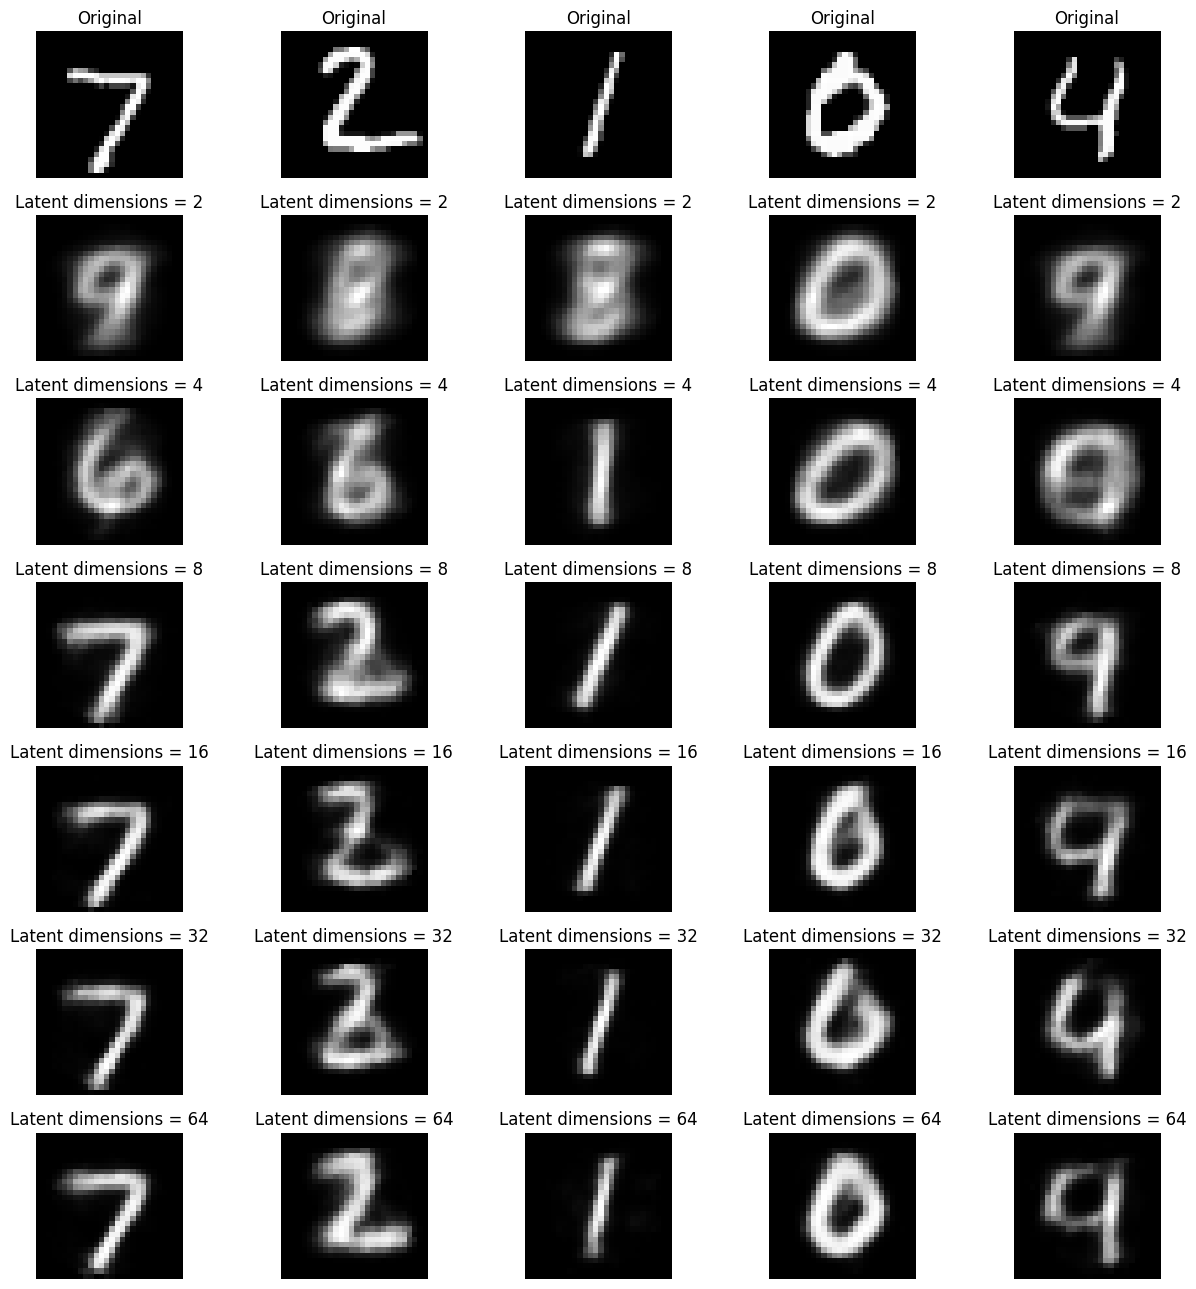

In [ ]:
fig = plt.figure(figsize = (13, 13))
rows, cols = 7, 5

test_features_batch, test_labels_batch = next(iter(test_dataloader))
for j in range(5):
  fig.add_subplot(rows, cols, j+1)
  plt.imshow(test_features_batch[j].squeeze(), cmap="gray")
  plt.title("Original")
  plt.axis(False)
  plt.subplots_adjust(hspace=0.4)

plt.savefig('plot_og.png')
for k,model in enumerate(MODELS):
  model.eval()

  with torch.inference_mode():
    _,_,re_x = model(test_features_batch.flatten(start_dim=1).to(DEVICE))

  for j in range(5):
    re_x_shaped=re_x[j].reshape(28,28)

    fig.add_subplot(rows, cols, (k+1)*5+(j+1))
    plt.imshow(re_x_shaped.detach().to("cpu").numpy(), cmap="gray")
    plt.title(f"Latent dimensions = {2**(k+1)}")
    plt.axis(False)
    plt.subplots_adjust(bottom=0.1, top=0.9)

plt.tight_layout()
plt.savefig('plot.png')

In [ ]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

In [ ]:
mse_vals=[]
test_dataloader = DataLoader(dataset = testset,
                              batch_size = BATCH_SIZE,
                              shuffle = False)

for model in MODELS:
  model.eval()
  mse_val=0
  with torch.inference_mode():
    for x_test, y in test_dataloader:
      _,_,re_x_test = model(x_test.flatten(start_dim=1).to(DEVICE))

      x_test_flat = x_test.flatten().to("cpu").numpy()
      re_x_test_flat = re_x_test.flatten().detach().to("cpu").numpy()

      mse_val += mse(x_test_flat, re_x_test_flat)


  mse_val /= len(test_dataloader)
  mse_vals.append(mse_val)

print(f"MSE values are = {mse_vals}")

MSE values are = [0.059044731073081495, 0.05195353992283344, 0.04281864296644926, 0.035697294492274524, 0.03363200068473816, 0.034396068155765534]
